In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import sklearn
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [3]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


In [4]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            


            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    



    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    
    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [4]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [5]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

In [6]:
ml_list={"DT":DecisionTreeClassifier()}#,"SVC":SVC()}}

In [7]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [8]:
folder("results")
folder("pdfs")

## Calculation of evaluations

In [10]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [11]:
def ML_CV(loop1,loop2,output_csv,cols,dname,sw):
    fold=5
    repetition=10

    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  


            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  




            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)

        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        #print (tabulate(results, headers=list(results.columns)))
        #print()

In [11]:
attack_dict={'Active Wiretap':"AWT",
 'ARP MitM':"ARPMitM",
 'Fuzzing':"Fuzzing",
 'Mirai':"Mirai",
 'OS Scan':"OS_Scan",
 'SSDP Flood':"SSDP_F",
 'SSL Renegotiation':"SSL_Ren",
 'SYN DoS':"SYN_F",
 'Video Injection':"Vid_Inj"}

In [12]:
features=['ts', 'pck_size', 'payload_bytes','entropy','TCP_window','pck_size_diff','pck_size_mean','pck_size_std',
'ts_diff', 'ts_mean', 'ts_std','TCP_window_diff','TCP_window_mean','TCP_window_std',
'payload_bytes_diff' ,'payload_bytes_mean','payload_bytes_std',
'entropy_diff','entropy_mean','entropy_std',"Label"]

In [13]:
len(features)

21

# ONLY MiTM

In [15]:
MiTM=["AWT","ARPMitM","Vid_Inj"]

In [49]:
for i in tqdm(range(2,21)):
    print(f"{45*'#'} {i} {45*'#'}\n")
    file_list=find_the_way("SW",f"last_{i}_","train")
    for ii in (file_list):
        temp=ii.split("_")[2]
        output_csv=f"./results/ML_{i}_{temp}.csv"
        target_names=["attack","benign"]
        dname=attack_dict[temp]  
        if dname in MiTM:
            feature,_=GA(ii,ii.replace("train","test"),features,gen_number=25,outputcsv=f"{i}_{dname}_GA_output.csv")
            print(f"{dname} : {feature}\n\n")
            ML_CV(ii,ii.replace("train","test"),output_csv,feature,dname,i)   



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

############################################# 2 #############################################

AWT : ['ts', 'TCP_window', 'payload_bytes', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'Label']


ARPMitM : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


Vid_Inj : ['ts', 'pck_size', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_std', 'Label']




  5%|████                                                                          | 1/19 [52:09<15:38:52, 3129.58s/it]

############################################# 3 #############################################

AWT : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_mean', 'payload_bytes_mean', 'Label']


ARPMitM : ['entropy', 'ts_mean', 'ts_std', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_diff', 'Label']


Vid_Inj : ['pck_size', 'payload_bytes', 'entropy', 'pck_size_std', 'ts_diff', 'ts_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']




 11%|████████                                                                    | 2/19 [1:44:54<14:52:35, 3150.33s/it]

############################################# 4 #############################################

AWT : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'pck_size_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'Label']


ARPMitM : ['pck_size', 'payload_bytes', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


Vid_Inj : ['ts', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']




 16%|████████████                                                                | 3/19 [2:32:55<13:27:20, 3027.52s/it]

############################################# 5 #############################################

AWT : ['ts', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


ARPMitM : ['pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']




 21%|████████████████                                                            | 4/19 [3:25:13<12:47:44, 3071.00s/it]

############################################# 6 #############################################

AWT : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


ARPMitM : ['ts', 'entropy', 'pck_size_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'pck_size_diff', 'ts_std', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']




 26%|████████████████████                                                        | 5/19 [4:13:48<11:43:25, 3014.66s/it]

############################################# 7 #############################################

AWT : ['ts', 'pck_size', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


ARPMitM : ['pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'ts_diff', 'ts_mean', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'Label']


Vid_Inj : ['ts', 'pck_size', 'entropy', 'pck_size_diff', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']




 32%|████████████████████████                                                    | 6/19 [5:11:01<11:24:01, 3157.02s/it]

############################################# 8 #############################################

AWT : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_std', 'Label']


ARPMitM : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_std', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'Label']




 37%|████████████████████████████                                                | 7/19 [6:07:28<10:46:27, 3232.31s/it]

############################################# 9 #############################################

AWT : ['ts', 'pck_size_diff', 'pck_size_std', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


ARPMitM : ['payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'entropy_mean', 'entropy_std', 'Label']


Vid_Inj : ['pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'Label']




 42%|████████████████████████████████                                            | 8/19 [7:03:35<10:00:26, 3275.14s/it]

############################################# 10 #############################################

AWT : ['ts', 'pck_size', 'TCP_window', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'TCP_window_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


ARPMitM : ['ts', 'pck_size', 'payload_bytes', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_mean', 'ts_std', 'TCP_window_mean', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_mean', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']




 47%|████████████████████████████████████▍                                        | 9/19 [8:01:09<9:15:10, 3331.04s/it]

############################################# 11 #############################################

AWT : ['ts', 'pck_size', 'payload_bytes', 'pck_size_mean', 'ts_diff', 'ts_std', 'TCP_window_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


ARPMitM : ['payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'pck_size', 'payload_bytes', 'pck_size_diff', 'pck_size_mean', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']




 53%|████████████████████████████████████████                                    | 10/19 [8:54:53<8:14:42, 3298.04s/it]

############################################# 12 #############################################

AWT : ['ts', 'pck_size', 'payload_bytes', 'entropy', 'pck_size_diff', 'ts_diff', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


ARPMitM : ['ts', 'pck_size', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_mean', 'entropy_mean', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'pck_size', 'payload_bytes', 'entropy', 'pck_size_mean', 'ts_mean', 'ts_std', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']




 58%|████████████████████████████████████████████                                | 11/19 [9:52:46<7:26:52, 3351.53s/it]

############################################# 13 #############################################

AWT : ['ts', 'TCP_window', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'Label']


ARPMitM : ['pck_size', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'TCP_window_std', 'payload_bytes_std', 'entropy_diff', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']




 63%|███████████████████████████████████████████████▎                           | 12/19 [10:50:18<6:34:34, 3382.12s/it]

############################################# 14 #############################################

AWT : ['ts', 'TCP_window', 'payload_bytes', 'ts_diff', 'ts_mean', 'TCP_window_mean', 'payload_bytes_diff', 'entropy_diff', 'entropy_mean', 'Label']


ARPMitM : ['TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'TCP_window_diff', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'Label']




 68%|███████████████████████████████████████████████████▎                       | 13/19 [11:43:26<5:32:20, 3323.35s/it]

############################################# 15 #############################################

AWT : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_mean', 'Label']


ARPMitM : ['ts', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_mean', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'Label']




 74%|███████████████████████████████████████████████████████▎                   | 14/19 [12:45:04<4:46:22, 3436.45s/it]

############################################# 16 #############################################

AWT : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


ARPMitM : ['ts', 'pck_size', 'payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'pck_size', 'payload_bytes', 'entropy', 'pck_size_mean', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_std', 'Label']




 79%|███████████████████████████████████████████████████████████▏               | 15/19 [13:50:49<3:59:18, 3589.68s/it]

############################################# 17 #############################################

AWT : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']


ARPMitM : ['pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_mean', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'Label']




 84%|███████████████████████████████████████████████████████████████▏           | 16/19 [14:49:48<2:58:42, 3574.33s/it]

############################################# 18 #############################################

AWT : ['ts', 'pck_size', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_std', 'Label']


ARPMitM : ['pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_std', 'Label']


Vid_Inj : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'ts_mean', 'ts_std', 'TCP_window_std', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'Label']




 89%|███████████████████████████████████████████████████████████████████        | 17/19 [15:57:45<2:04:10, 3725.49s/it]

############################################# 19 #############################################

AWT : ['ts', 'pck_size', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_mean', 'Label']


ARPMitM : ['TCP_window', 'payload_bytes', 'entropy', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


Vid_Inj : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']




 95%|███████████████████████████████████████████████████████████████████████    | 18/19 [17:04:06<1:03:22, 3802.27s/it]

############################################# 20 #############################################

AWT : ['ts', 'pck_size', 'payload_bytes', 'pck_size_diff', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_diff', 'entropy_std', 'Label']


ARPMitM : ['ts', 'pck_size', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'Label']


Vid_Inj : ['ts', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_mean', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']




100%|█████████████████████████████████████████████████████████████████████████████| 19/19 [18:03:52<00:00, 3422.78s/it]


In [33]:
name_list

['./results/DT_10_Active Wiretap.csv',
 './results/DT_10_ARP MitM.csv',
 './results/DT_10_Fuzzing.csv',
 './results/DT_10_Mirai.csv',
 './results/DT_10_OS Scan.csv',
 './results/DT_10_SSDP Flood.csv',
 './results/DT_10_SSL Renegotiation.csv',
 './results/DT_10_SYN DoS.csv',
 './results/DT_10_Video Injection.csv',
 './results/DT_11_Active Wiretap.csv',
 './results/DT_11_ARP MitM.csv',
 './results/DT_11_Fuzzing.csv',
 './results/DT_11_Mirai.csv',
 './results/DT_11_OS Scan.csv',
 './results/DT_11_SSDP Flood.csv',
 './results/DT_11_SSL Renegotiation.csv',
 './results/DT_11_SYN DoS.csv',
 './results/DT_11_Video Injection.csv',
 './results/DT_12_Active Wiretap.csv',
 './results/DT_12_ARP MitM.csv',
 './results/DT_12_Fuzzing.csv',
 './results/DT_12_Mirai.csv',
 './results/DT_12_OS Scan.csv',
 './results/DT_12_SSDP Flood.csv',
 './results/DT_12_SSL Renegotiation.csv',
 './results/DT_12_SYN DoS.csv',
 './results/DT_12_Video Injection.csv',
 './results/DT_13_Active Wiretap.csv',
 './results/DT_1

      SW  Dataset               Acc     b_Acc      Prec       Rec        F1       kap       ROC      tra-T       test-T
--  ----  ---------------  --------  --------  --------  --------  --------  --------  --------  ---------  -----------
35     2  Video Injection  0.51186   0.51186   0.511862  0.51186   0.511841   0.02372  0.51186   0.186206   0.00435209
34     2  ARP MitM         0.507555  0.507555  0.50756   0.507555  0.50748    0.01511  0.507555  0.147002   0.00369897
33     2  Active Wiretap   0.531855  0.531855  0.531861  0.531855  0.531835   0.06371  0.531855  0.105089   0.00418489
37     3  ARP MitM         0.50025   0.50025   0.50025   0.50025   0.500231   0.0005   0.50025   0.122963   0.0035013
38     3  Video Injection  0.51029   0.51029   0.51029   0.51029   0.510286   0.02058  0.51029   0.181816   0.00366292
36     3  Active Wiretap   0.53056   0.53056   0.530561  0.53056   0.530558   0.06112  0.53056   0.132256   0.0039181
39     4  Active Wiretap   0.53841   0.53841   0

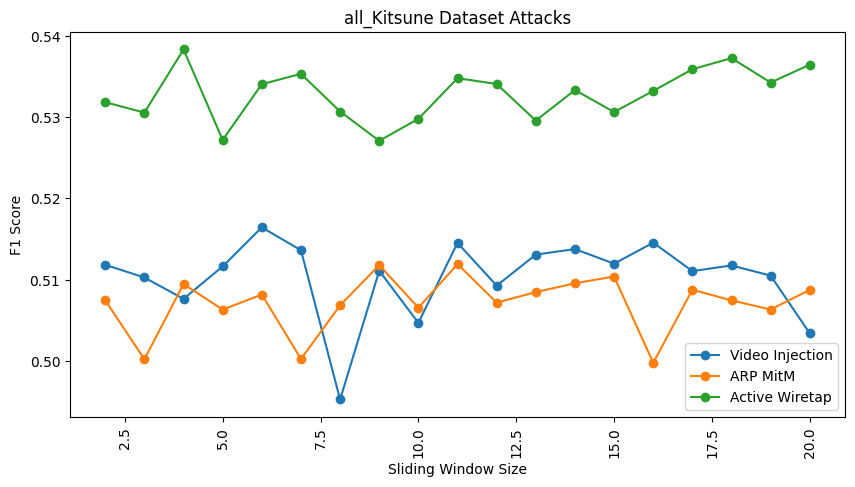

Vid_Inj
ARPMitM
AWT


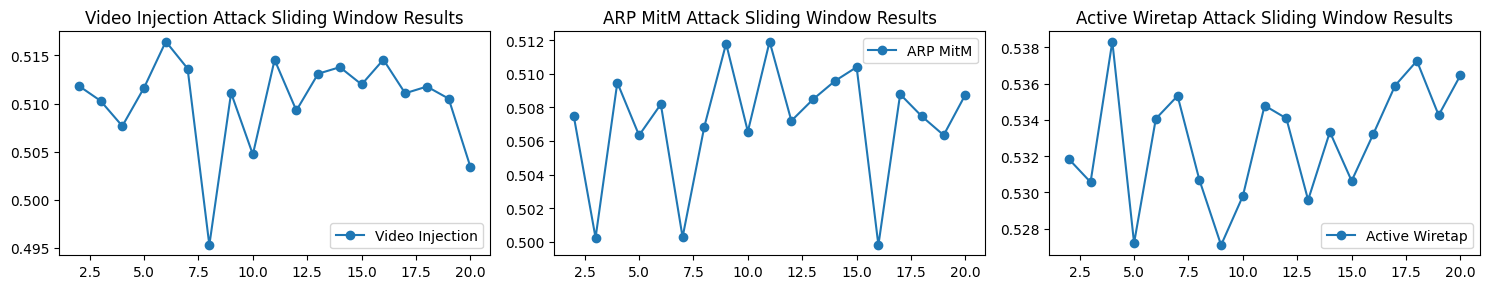

In [35]:
name_list=find_the_way('./results/','.csv')
lines=[["SW","Dataset","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
cols=['Acc', 'b_Acc', 'Prec', 'Rec', 'F1','kap', 'ROC', 'tra-T', 'test-T']
for p in name_list:
    
    df = pd.read_csv(p,usecols=cols) 
    temp=pd.DataFrame(df.mean())
    a=list(temp.values.flatten())
    add_data=p[:-4].split("_")[1:]
    add_data=[int(add_data[0]),add_data[1]]
    add_data=add_data+a
    lines.append(add_data)
results = pd.DataFrame (lines[1:], columns = lines[0])
results=results.sort_values('SW')

print (tabulate(results, headers=list(results.columns)))
my_xticks=list(range(2,21))
for j in ['F1']:#['Acc', 'b_Acc',  'F1', 'kap', 'ROC']:
    plt.figure(figsize=(10,5))
    graph_name=f"all_Kitsune Dataset Attacks"
    plt.title(graph_name)
    plt.ylabel(evaluate[j])
    plt.xlabel("Sliding Window Size")
    for p in results["Dataset"].unique():
        dname=attack_dict[p]  
        if dname in MiTM:
            df=results[results["Dataset"]==p]
            plt.plot(my_xticks,df[j], linestyle='-', marker='o',label= p)
    plt.legend(numpoints=1)
    plt.xticks(rotation=90) 
    graph_name=f"./pdfs/all_Kitsune Dataset-{j} Attack-mitm.pdf"
    plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
    plt.show()
my_xticks=list(range(2,21))
for j in ['F1']:#['Acc', 'b_Acc',  'F1', 'kap', 'ROC']:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
    for pp,p in enumerate(results["Dataset"].unique()):
        dname=attack_dict[p]  
        if dname in MiTM:
            print(dname)
            df=results[results["Dataset"]==p]
            axes[pp%3].plot(my_xticks,df[j], linestyle='-', marker='o',label= p)
            axes[pp%3].title.set_text(f'{p} Attack Sliding Window Results')
            axes[pp%3].legend()
            fig.tight_layout()
graph_name=f"./pdfs/ind_Kitsune Dataset-{j} Attack_mitm.pdf"
fig.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
fig.show()

In [26]:
print(my_xticks,df[j])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 100    0.507480
109    0.500231
118    0.509483
127    0.506337
136    0.508191
145    0.500266
154    0.506860
163    0.511810
1      0.506562
10     0.511931
19     0.507204
28     0.508488
37     0.509575
46     0.510403
55     0.499794
64     0.508788
73     0.507466
82     0.506348
91     0.508769
Name: F1, dtype: float64


# ALL ATTACKS

In [17]:
for i in tqdm(range(2,21)):
    print(f"{45*'#'} {i} {45*'#'}\n")
    file_list=find_the_way("C:/Users/kahraman/Desktop/Kitsune/SW/SW/",f"last_{i}_","train")
    for ii in (file_list):
        temp=ii.split("_")[2]
        output_csv=f"./results/ML_{i}_{temp}.csv"
        target_names=["attack","benign"]
        dname=attack_dict[temp]  
        if dname not in MiTM:
            feature,_=GA(ii,ii.replace("train","test"),features,gen_number=25,outputcsv=f"{i}_{dname}_GA_output.csv")
            print(f"{dname} : {feature}\n\n")
            ML_CV(ii,ii.replace("train","test"),output_csv,feature,dname,i)   



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

############################################# 2 #############################################

Fuzzing : ['TCP_window', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_mean', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


Mirai : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'ts_mean', 'ts_std', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'Label']


OS_Scan : ['pck_size', 'TCP_window', 'pck_size_mean', 'ts_diff', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_diff', 'payload_bytes_diff', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


SSL_Ren : ['ts', 'payload_bytes', 'pck_size_mean', 'pck_size_std', 'TCP_window_diff', 'TC

  5%|████                                                                        | 1/19 [2:12:34<39:46:29, 7954.95s/it]

############################################# 3 #############################################

Fuzzing : ['ts', 'pck_size', 'payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'entropy_diff', 'Label']


Mirai : ['ts', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


OS_Scan : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'pck_size_diff', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'Label']


SSL_

 11%|████████                                                                    | 2/19 [4:49:14<41:34:38, 8804.65s/it]

############################################# 4 #############################################

Fuzzing : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_std', 'Label']


Mirai : ['TCP_window', 'entropy', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


OS_Scan : ['pck_size', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_mean', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']


SSDP_F : ['pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_std', 'Label']


SSL_Ren : ['ts', 'pck_size',

 16%|████████████                                                                | 3/19 [7:10:02<38:24:29, 8641.83s/it]

############################################# 5 #############################################

Fuzzing : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Mirai : ['ts', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


OS_Scan : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_std', 'entropy_di

 21%|████████████████                                                            | 4/19 [9:37:11<36:18:56, 8715.76s/it]

############################################# 6 #############################################

Fuzzing : ['ts', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Mirai : ['TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_std', 'TCP_window_diff', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'Label']


OS_Scan : ['TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'ts_mean', 'TCP_window_diff', 'payload_bytes_diff', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'entropy_diff', 'entropy_mean', 'Label']


SSL_Ren : ['pck_size', 'TCP_window', 'pck_size_diff', 'pck_size

 26%|███████████████████▋                                                       | 5/19 [11:45:22<32:27:26, 8346.19s/it]

############################################# 7 #############################################

Fuzzing : ['pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Mirai : ['pck_size', 'TCP_window', 'entropy', 'pck_size_mean', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'Label']


OS_Scan : ['ts', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_mean', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_std', 'Label']


SSL_Ren : ['TCP_window', 'payload_bytes', 'pck_size_diff', 'pck_size_mean'

 32%|███████████████████████▋                                                   | 6/19 [13:50:44<29:07:37, 8065.99s/it]

############################################# 8 #############################################

Fuzzing : ['TCP_window', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_mean', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_std', 'Label']


Mirai : ['TCP_window', 'payload_bytes', 'entropy', 'pck_size_std', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


OS_Scan : ['pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'ts_mean', 'TCP_window_diff', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_std', 'ts_mean', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 

 37%|███████████████████████████▋                                               | 7/19 [15:46:39<25:40:32, 7702.74s/it]

############################################# 9 #############################################

Fuzzing : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


Mirai : ['pck_size', 'payload_bytes', 'entropy', 'pck_size_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_std', 'Label']


OS_Scan : ['TCP_window', 'entropy', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_mean', 'payload_bytes_diff', 'entropy_diff', 'entropy_mean', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'ts_mean', 'TCP_window_diff', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_std', 'Label']


SSL_Ren : ['pck_size', 'TCP_window', 'payload_bytes'

 42%|███████████████████████████████▌                                           | 8/19 [17:50:28<23:16:12, 7615.66s/it]

############################################# 10 #############################################

Fuzzing : ['ts', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']


Mirai : ['ts', 'pck_size', 'payload_bytes', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


OS_Scan : ['ts', 'TCP_window', 'payload_bytes', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_std', 'payload_bytes_diff', 'entropy_diff', 'entropy_mean', 'Label']


SSDP_F : ['pck_size', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'TCP_window_std', 'payload_bytes_mean', 'payload_bytes_std', 'Label']


 47%|███████████████████████████████████▌                                       | 9/19 [20:10:33<21:50:25, 7862.53s/it]

############################################# 11 #############################################

Fuzzing : ['ts', 'pck_size', 'payload_bytes', 'pck_size_mean', 'pck_size_std', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


Mirai : ['ts', 'pck_size', 'TCP_window', 'ts_diff', 'ts_std', 'TCP_window_diff', 'payload_bytes_diff', 'entropy_diff', 'entropy_std', 'Label']


OS_Scan : ['ts', 'pck_size', 'TCP_window', 'pck_size_diff', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'Label']


SSDP_F : ['ts', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


SSL_Ren : ['ts', 'TCP_wi

 53%|██████████████████████████████████████▉                                   | 10/19 [22:29:40<20:01:48, 8012.03s/it]

############################################# 12 #############################################

Fuzzing : ['TCP_window', 'entropy', 'pck_size_diff', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Mirai : ['ts', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_std', 'TCP_window_mean', 'payload_bytes_diff', 'entropy_diff', 'entropy_mean', 'Label']


OS_Scan : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


SSDP_F : ['pck_size', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_std', 'TCP_window_diff', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


SSL_Ren : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'e

 58%|██████████████████████████████████████████▊                               | 11/19 [24:47:07<17:57:51, 8083.94s/it]

############################################# 13 #############################################

Fuzzing : ['pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


Mirai : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'Label']


OS_Scan : ['TCP_window', 'payload_bytes', 'entropy', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_mean', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'payload_bytes_diff', 'payload_bytes_mean', 'Label']


SSL_Ren : ['ts', 'pck_size', 'payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_mean', 'TCP

 63%|██████████████████████████████████████████████▋                           | 12/19 [26:47:06<15:11:42, 7814.62s/it]

############################################# 14 #############################################

Fuzzing : ['TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']


Mirai : ['ts', 'pck_size', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'Label']


OS_Scan : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'pck_size_diff', 'pck_size_std', 'ts_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_std', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_diff', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']


SSL_Ren : ['ts', 'TCP

 68%|██████████████████████████████████████████████████▋                       | 13/19 [28:44:22<12:37:53, 7578.84s/it]

############################################# 15 #############################################

Fuzzing : ['ts', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_mean', 'entropy_mean', 'Label']


Mirai : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'entropy_diff', 'Label']


OS_Scan : ['pck_size', 'TCP_window', 'payload_bytes', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_mean', 'Label']


SSL_Ren : ['pck_size', 'p

 74%|██████████████████████████████████████████████████████▌                   | 14/19 [30:44:28<10:22:10, 7466.10s/it]

############################################# 16 #############################################

Fuzzing : ['TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'entropy_mean', 'Label']


Mirai : ['ts', 'pck_size', 'payload_bytes', 'pck_size_mean', 'pck_size_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']


OS_Scan : ['TCP_window', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_mean', 'entropy_mean', 'entropy_std', 'Label']


SSDP_F : ['ts', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_std', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'Label']


SSL_Ren : ['ts', 'TCP_window', 'payload_bytes', 'entropy', 

 79%|███████████████████████████████████████████████████████████▏               | 15/19 [32:53:30<8:23:16, 7549.21s/it]

############################################# 17 #############################################

Fuzzing : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_diff', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_mean', 'Label']


Mirai : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'ts_diff', 'ts_std', 'TCP_window_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_std', 'Label']


OS_Scan : ['TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_std', 'Label']


SSDP_F : ['pck_size', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'Label']


SSL_Ren : ['ts', 'pck_size', 'payload_bytes', 'pck_size_diff', 'pck_size_mean'

 84%|███████████████████████████████████████████████████████████████▏           | 16/19 [35:08:23<6:25:39, 7713.14s/it]

############################################# 18 #############################################

Fuzzing : ['ts', 'pck_size', 'TCP_window', 'payload_bytes', 'pck_size_mean', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_mean', 'payload_bytes_mean', 'entropy_std', 'Label']


Mirai : ['ts', 'pck_size', 'payload_bytes', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_diff', 'entropy_std', 'Label']


OS_Scan : ['ts', 'pck_size', 'payload_bytes', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_std', 'TCP_window_diff', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'entropy_mean', 'entropy_std', 'Label']


SSL_Ren : ['pck_size', 'TCP_

 89%|███████████████████████████████████████████████████████████████████        | 17/19 [37:12:00<4:14:07, 7623.98s/it]

############################################# 19 #############################################

Fuzzing : ['TCP_window', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_mean', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


Mirai : ['ts', 'pck_size', 'TCP_window', 'pck_size_diff', 'ts_diff', 'ts_mean', 'TCP_window_std', 'payload_bytes_diff', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


OS_Scan : ['ts', 'TCP_window', 'payload_bytes', 'entropy', 'pck_size_mean', 'ts_diff', 'ts_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_mean', 'entropy_std', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'pck_size_diff', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_std', 'Label']


SSL_Ren : ['pck_size', 'TCP_window', 'payload_bytes'

 95%|███████████████████████████████████████████████████████████████████████    | 18/19 [39:31:10<2:10:42, 7842.00s/it]

############################################# 20 #############################################

Fuzzing : ['payload_bytes', 'entropy', 'pck_size_mean', 'pck_size_std', 'ts_diff', 'ts_std', 'TCP_window_diff', 'TCP_window_mean', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_std', 'entropy_diff', 'entropy_mean', 'Label']


Mirai : ['ts', 'pck_size', 'TCP_window', 'entropy', 'pck_size_diff', 'pck_size_mean', 'pck_size_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'entropy_std', 'Label']


OS_Scan : ['ts', 'pck_size', 'payload_bytes', 'pck_size_diff', 'pck_size_mean', 'ts_diff', 'ts_std', 'TCP_window_diff', 'payload_bytes_diff', 'payload_bytes_mean', 'entropy_diff', 'entropy_mean', 'Label']


SSDP_F : ['ts', 'pck_size', 'TCP_window', 'pck_size_diff', 'ts_diff', 'ts_mean', 'ts_std', 'TCP_window_diff', 'TCP_window_std', 'payload_bytes_mean', 'payload_bytes_std', 'entropy_std', 'Label']


SSL_Ren : ['ts', 'entrop

100%|█████████████████████████████████████████████████████████████████████████████| 19/19 [41:44:25<00:00, 7908.68s/it]


       SW  Dataset                 Acc     b_Acc      Prec       Rec        F1          kap       ROC      tra-T       test-T
---  ----  -----------------  --------  --------  --------  --------  --------  -----------  --------  ---------  -----------
107     2  Video Injection    0.51186   0.51186   0.511862  0.51186   0.511841   0.02372     0.51186   0.186206   0.00435209
106     2  SYN DoS            0.600887  0.509431  0.512074  0.509431  0.499169   0.0202402   0.509431  0.117181   0.00156295
105     2  SSL Renegotiation  0.51021   0.51021   0.510244  0.51021   0.509807   0.02042     0.51021   0.277745   0.00937746
104     2  SSDP Flood         0.512145  0.512145  0.512544  0.512145  0.508257   0.02429     0.512145  0.131245   0.00781355
 99     2  Active Wiretap     0.531855  0.531855  0.531861  0.531855  0.531835   0.06371     0.531855  0.105089   0.00418489
102     2  Mirai              0.51651   0.51651   0.518899  0.51651   0.500439   0.03302     0.51651   0.164058   0.0062510

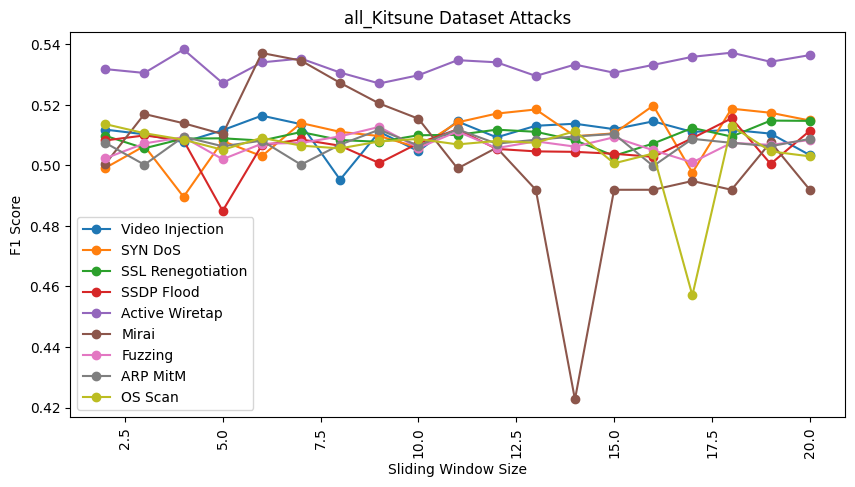

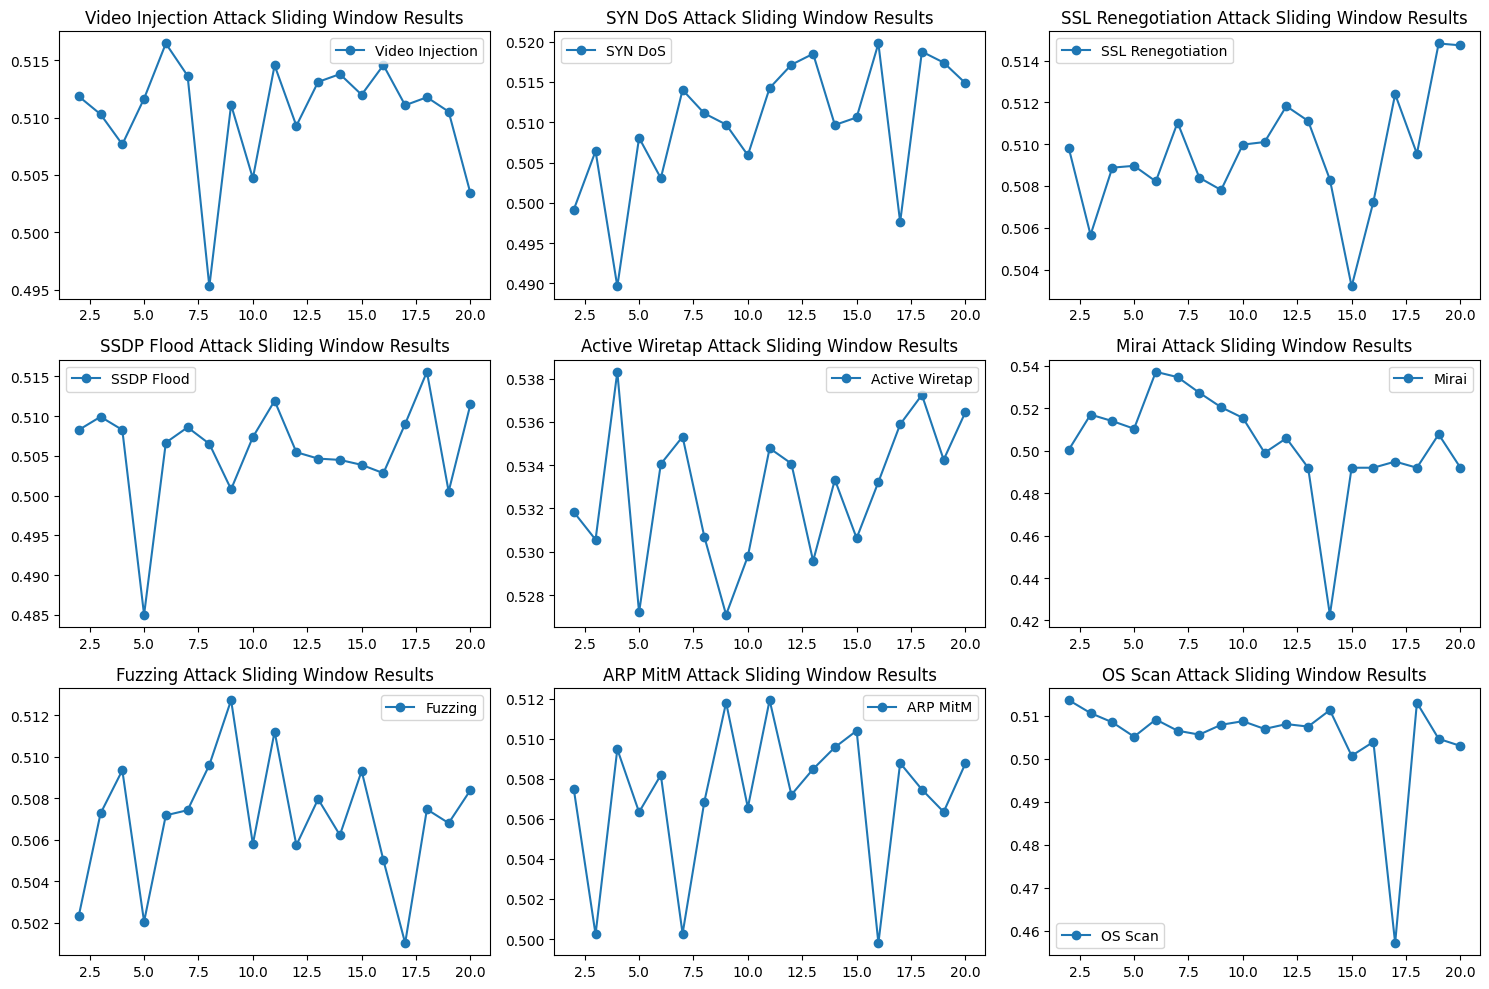

In [36]:
name_list=find_the_way('./results/','.csv')
lines=[["SW","Dataset","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
cols=['Acc', 'b_Acc', 'Prec', 'Rec', 'F1','kap', 'ROC', 'tra-T', 'test-T']
for p in name_list:
    df = pd.read_csv(p,usecols=cols) 
    temp=pd.DataFrame(df.mean())
    a=list(temp.values.flatten())
    add_data=p[:-4].split("_")[1:]
    add_data=[int(add_data[0]),add_data[1]]
    add_data=add_data+a
    lines.append(add_data)
results = pd.DataFrame (lines[1:], columns = lines[0])
results=results.sort_values('SW')

print (tabulate(results, headers=list(results.columns)))
my_xticks=list(range(2,21))
for j in ['F1']:#['Acc', 'b_Acc',  'F1', 'kap', 'ROC']:
    plt.figure(figsize=(10,5))
    graph_name=f"all_Kitsune Dataset Attacks"
    plt.title(graph_name)
    plt.ylabel(evaluate[j])
    plt.xlabel("Sliding Window Size")
    for p in results["Dataset"].unique():
        df=results[results["Dataset"]==p]


        plt.plot(my_xticks,df[j], linestyle='-', marker='o',label= p)


    plt.legend(numpoints=1)
    plt.xticks(rotation=90) 
    graph_name=f"./pdfs/all_Kitsune Dataset-{j} Attack-_not_mitm.pdf"
    plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
    plt.show()
my_xticks=list(range(2,21))
for j in ['F1']:#['Acc', 'b_Acc',  'F1', 'kap', 'ROC']:
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    for pp,p in enumerate(results["Dataset"].unique()):
        df=results[results["Dataset"]==p]
        axes[pp//3,pp%3].plot(my_xticks,df[j], linestyle='-', marker='o',label= p)
        axes[pp//3,pp%3].title.set_text(f'{p} Attack Sliding Window Results')
        axes[pp//3,pp%3].legend()
    fig.tight_layout()
    graph_name=f"./pdfs/ind_Kitsune Dataset-{j} Attack_not_mitm.pdf"
    fig.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
    plt.show()